# Course 5 - Deep Learning and Reinforcement Learning

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle
import tensorflow

from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from datetime import datetime

C:\Users\sarth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sarth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sarth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sarth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [2]:
foldernames = os.listdir('image_data/raw-img')
categories = []
files = []
i = 0
for k, folder in enumerate(foldernames):
    filenames = os.listdir("image_data/raw-img/" + folder);
    for file in filenames:
        files.append("image_data/raw-img/" + folder + "/" + file)
        categories.append(k)
        
df = pd.DataFrame({
    'filename': files,
    'category': categories
})

data_df = pd.DataFrame(columns=['filename', 'category'])
for i in range(10):
    data_df = data_df.append(df[df.category == i].iloc[:500,:])


data_df = data_df.reset_index(drop=True)
data_df.head()

,filename,category
0,image_data/raw-img/0dog/OIF-e2bexWrojgtQnAPPcU...,0
1,image_data/raw-img/0dog/OIP---A27bIBcUgX1qkbpZ...,0
2,image_data/raw-img/0dog/OIP---cByAiEbIxIAleGo9...,0
3,image_data/raw-img/0dog/OIP---ZIdwfUcJeVxnh47z...,0
4,image_data/raw-img/0dog/OIP---ZRsOF7zsMqhW30We...,0


Animal Classification data from Kaggle: https://www.kaggle.com/min4tozaki/animal-classification

10 categories of animals (0-9), in order in the dataset. 500 images for each category.
- Shuffle is needed
- Add name of animal to another column
- Images are of different sizes

In [3]:
names = {0:"dog", 9:"squirrel", 2:"elephant", 1:"horse", 8:"spider", 4:"chicken", 7:"sheep",5:"cat", 6:"cow", 3:"butterfly"}

data_df['name'] = data_df['category'].map(names)
data_df.head()

,filename,category,name
0,image_data/raw-img/0dog/OIF-e2bexWrojgtQnAPPcU...,0,dog
1,image_data/raw-img/0dog/OIP---A27bIBcUgX1qkbpZ...,0,dog
2,image_data/raw-img/0dog/OIP---cByAiEbIxIAleGo9...,0,dog
3,image_data/raw-img/0dog/OIP---ZIdwfUcJeVxnh47z...,0,dog
4,image_data/raw-img/0dog/OIP---ZRsOF7zsMqhW30We...,0,dog


C:\Users\sarth\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5000 [00:00<?, ?it/s]

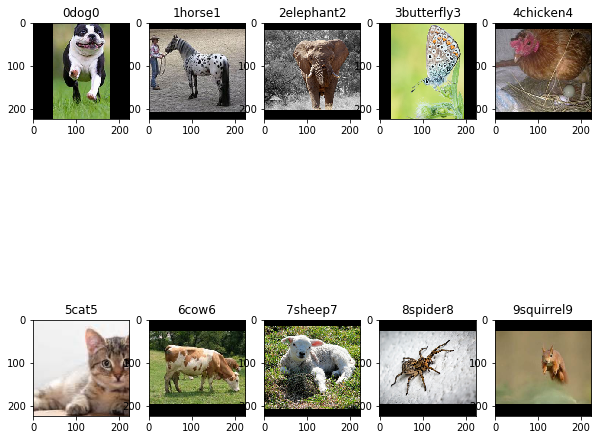

In [4]:
def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    

    # centering [extra space on each side to make 256 total]
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2

    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8) # 256*256*3
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img  

    return resized

images = []

# tqdm for progress bar
with tqdm(total=len(data_df)) as pbar:
    for i, file_path in enumerate(data_df.filename.values):
        #read image
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resize [find dim and size to resize]
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering
        img = centering_image(cv2.resize(img, dsize=tile_size)) #resize higher dimension to <256

        #out put 224*224px 
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)

rows,cols = 2,5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))
for i in range(10):
    path = data_df[data_df.category == i].values[2]
#     image = cv2.imread(path[0])/
    axes[i//cols, i%cols].set_title(path[0].split('/')[-2] + str(path[1]))
    axes[i//cols, i%cols].imshow(images[data_df[data_df.filename == path[0]].index[0]])

In [5]:
data_num = 5000
random_index = np.random.permutation(data_num)

x = []
y = []
for i in range(data_num):
    x.append(images[random_index[i]])
    y.append(data_df.iloc[random_index[i],1])

# convert from list to array
x = np.array(x)
x = x.astype('float32')
y = np.array(y)

# scale x values to 0-1
x /= 255

# convert y to categorical
y = to_categorical(y)


In [6]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

print(x.shape)
print(y.shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5000, 224, 224, 3)
(5000, 10)
(4000, 224, 224, 3)
(1000, 224, 224, 3)
(4000, 10)
(1000, 10)


## Models

1) CNN 1

2) CNN 2

3) VGG16 pre-trained model

### CNN 1

In [14]:
img_rows, img_cols, img_channel = 224, 224, 3
num_classes = 10

# without padding

model1 = Sequential([
    Conv2D(9, 3, padding='valid', activation='relu', input_shape=(img_rows, img_cols, img_channel),use_bias=True),
    MaxPooling2D(pool_size=(5, 5)),
    Conv2D(27, 3, padding='valid', activation='relu',use_bias=True),
    MaxPooling2D(pool_size=(5, 5)),
#     Dropout(0.2),
    Flatten(),
    Dense(1000, activation='relu',use_bias=True),
    Dense(100, activation='relu',use_bias=True),
    Dense(num_classes, 'softmax')
])

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 222, 222, 9)       252       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 44, 44, 9)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 42, 42, 27)        2214      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 27)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1000)              1729000   
_________________________________________________________________
dense_19 (Dense)             (None, 100)               100100    
__________

In [8]:
# augmenting the images
"""
Image augmentation is a technique of applying different transformations to original images which results in multiple 
transformed copies of the same image. Each copy, however, is different from the other in certain aspects depending 
on the augmentation techniques you apply like shifting, rotating, flipping, etc.

Applying these small amounts of variations on the original image does not change its target class but only provides 
a new perspective of capturing the object in real life.
"""

epochs = 10
opt = tensorflow.keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)
batch_size = 50

train_datagen = ImageDataGenerator(
        rotation_range=15, 
        width_shift_range=0.15,
        height_shift_range=0.15, 
        horizontal_flip=True)
train_datagen.fit(x_train)



In [11]:
model1.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


t1 = datetime.now()
history_1= model1.fit(train_datagen.flow(x_train, y_train,batch_size=batch_size),
                      steps_per_epoch=x_train.shape[0] // batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test))

train_time_1 = datetime.now() - t1

Epoch 1/10
80/80 [==============================] - 127s 2s/step - loss: 2.1267 - acc: 0.2185 - val_loss: 1.9241 - val_acc: 0.3000
Epoch 2/10
80/80 [==============================] - 117s 1s/step - loss: 1.9482 - acc: 0.3018 - val_loss: 1.7015 - val_acc: 0.4130
Epoch 3/10
80/80 [==============================] - 72s 905ms/step - loss: 1.8462 - acc: 0.3262 - val_loss: 1.9255 - val_acc: 0.3250
Epoch 4/10
80/80 [==============================] - 75s 932ms/step - loss: 1.7663 - acc: 0.3668 - val_loss: 1.6143 - val_acc: 0.4330
Epoch 5/10
80/80 [==============================] - 76s 944ms/step - loss: 1.6984 - acc: 0.3932 - val_loss: 1.6999 - val_acc: 0.3940
Epoch 6/10
80/80 [==============================] - 76s 944ms/step - loss: 1.6491 - acc: 0.4080 - val_loss: 1.5290 - val_acc: 0.4530
Epoch 7/10
80/80 [==============================] - 76s 951ms/step - loss: 1.6095 - acc: 0.4260 - val_loss: 1.4677 - val_acc: 0.4870
Epoch 8/10
80/80 [==============================] - 77s 968ms/step - loss

0.506
0:14:05.601164


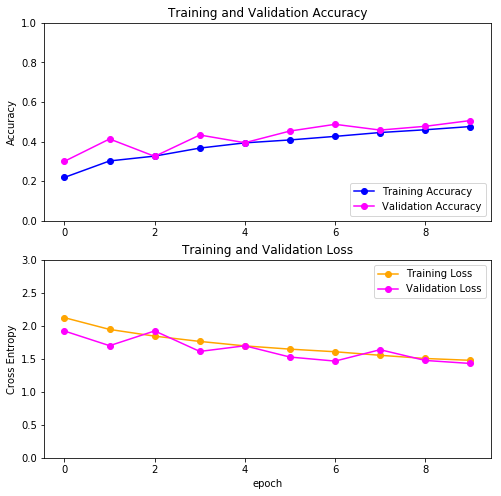

In [17]:
print(accuracy_score(np.argmax(y_test, axis = 1),model1.predict_classes(x_test)))
print(train_time_1)

acc = history_1.history['acc']
val_acc = history_1.history['val_acc']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', marker='o', color="blue")
plt.plot(val_acc, label='Validation Accuracy', marker='o', color="magenta",)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', marker='o', color="orange")
plt.plot(val_loss, label='Validation Loss', marker='o', color="magenta",)
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### CNN 2

In [14]:
model2 = Sequential([
    Conv2D(9, 3, padding='valid', activation='relu', input_shape=(img_rows, img_cols, img_channel),use_bias=True),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(27, 3, padding='valid', activation='relu',use_bias=True),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(81, 3, padding='valid', activation='relu',use_bias=True),
    MaxPooling2D(pool_size=(3, 3)),
#     Dropout(0.2),
    Flatten(),
    Dense(500,activation='relu',use_bias=True),
    Dense(100, activation='relu',use_bias=True),
    Dense(num_classes, 'softmax')
])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 9)       252       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 9)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 27)        2214      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 27)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 81)        19764     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 81)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3969)              0         
__________

In [15]:

model2.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


t2 = datetime.now()
history_2= model2.fit(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                      steps_per_epoch=x_train.shape[0] // batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test))

train_time_2 = datetime.now() - t2

Epoch 1/10
80/80 [==============================] - 88s 1s/step - loss: 2.2222 - acc: 0.1643 - val_loss: 2.1531 - val_acc: 0.1870
Epoch 2/10
80/80 [==============================] - 88s 1s/step - loss: 1.9746 - acc: 0.2812 - val_loss: 1.8140 - val_acc: 0.3540
Epoch 3/10
80/80 [==============================] - 87s 1s/step - loss: 1.8397 - acc: 0.3350 - val_loss: 1.7062 - val_acc: 0.3840
Epoch 4/10
80/80 [==============================] - 87s 1s/step - loss: 1.7469 - acc: 0.3805 - val_loss: 1.6730 - val_acc: 0.3950
Epoch 5/10
80/80 [==============================] - 87s 1s/step - loss: 1.6627 - acc: 0.4060 - val_loss: 1.5197 - val_acc: 0.4700
Epoch 6/10
80/80 [==============================] - 87s 1s/step - loss: 1.5776 - acc: 0.4450 - val_loss: 1.5451 - val_acc: 0.4410
Epoch 7/10
80/80 [==============================] - 87s 1s/step - loss: 1.5204 - acc: 0.4572 - val_loss: 1.4920 - val_acc: 0.4680
Epoch 8/10
80/80 [==============================] - 87s 1s/step - loss: 1.4757 - acc: 0.47

0.38
0:14:32.860475


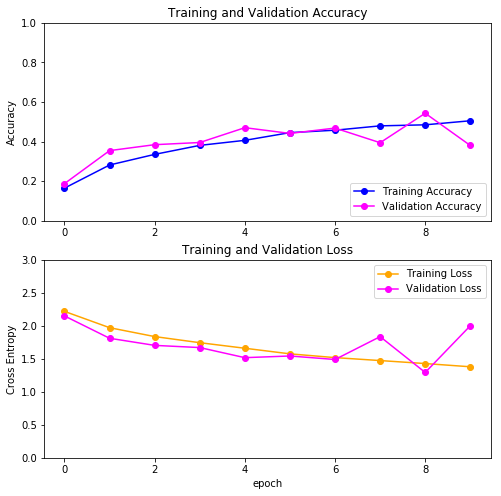

In [16]:
print(accuracy_score(np.argmax(y_test, axis = 1),model2.predict_classes(x_test)))
print(train_time_2)

acc = history_2.history['acc']
val_acc = history_2.history['val_acc']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', marker='o', color="blue")
plt.plot(val_acc, label='Validation Accuracy', marker='o', color="magenta",)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', marker='o', color="orange")
plt.plot(val_loss, label='Validation Loss', marker='o', color="magenta",)
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### CNN 3

In [13]:
model3 = Sequential([
    Conv2D(3, 3, padding='valid', activation='relu', input_shape=(img_rows, img_cols, img_channel),use_bias=True),
    Conv2D(6, 3, padding='valid', activation='relu',use_bias=True),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(9, 3, padding='valid', activation='relu',use_bias=True),
    Conv2D(12, 3, padding='valid', activation='relu',use_bias=True),
    MaxPooling2D(pool_size=(3, 3)),
#     Dropout(0.2),
    Flatten(),
    Dense(500,activation='relu',use_bias=True),
    Dense(100, activation='relu',use_bias=True),
    Dense(num_classes, 'softmax')
])

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 222, 222, 3)       84        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 220, 220, 6)       168       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 73, 73, 6)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 71, 71, 9)         495       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 69, 69, 12)        984       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 23, 23, 12)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6348)              0         
__________

In [15]:

model3.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


t3 = datetime.now()
history_3= model3.fit(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                      steps_per_epoch=x_train.shape[0] // batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test))

train_time_3 = datetime.now() - t3

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
80/80 [==============================] - 178s 2s/step - loss: 2.2048 - acc: 0.1775 - val_loss: 2.2210 - val_acc: 0.2240
Epoch 2/10
80/80 [==============================] - 172s 2s/step - loss: 2.0292 - acc: 0.2677 - val_loss: 1.9785 - val_acc: 0.2880
Epoch 3/10
80/80 [==============================] - 176s 2s/step - loss: 1.9339 - acc: 0.3018 - val_loss: 1.9248 - val_acc: 0.3150
Epoch 4/10
80/80 [==============================] - 193s 2s/step - loss: 1.8806 - acc: 0.3260 - val_loss: 1.7099 - val_acc: 0.3930
Epoch 5/10
80/80 [==============================] - 189s 2s/step - loss: 1.8262 - acc: 0.3490 - val_loss: 1.6899 - val_acc: 0.3860
Epoch 6/10
80/80 [==============================] - 190s 2s/step - loss: 1.7661 - acc: 0.3738 - val_loss: 1.7081 - val_acc: 0.3790
Epoch 7/10
80/80 [==============================] - 189s 2s/step - loss: 1.7374 - acc: 0.3762 - val_loss: 1.7531 - val_acc: 0.3650
Epoch 8/10
80/80 [=================

0.452
0:31:00.279299


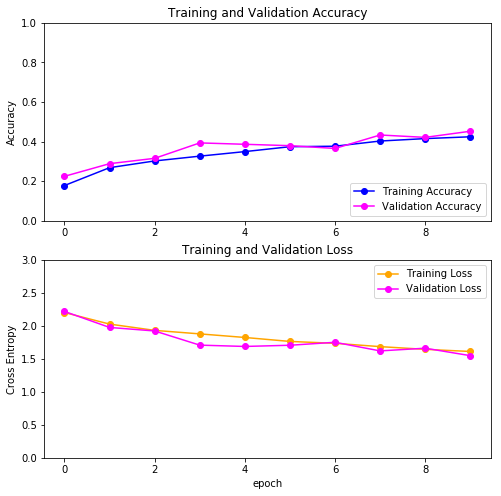

In [16]:
print(accuracy_score(np.argmax(y_test, axis = 1),model3.predict_classes(x_test)))
print(train_time_3)

acc = history_3.history['acc']
val_acc = history_3.history['val_acc']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', marker='o', color="blue")
plt.plot(val_acc, label='Validation Accuracy', marker='o', color="magenta",)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', marker='o', color="orange")
plt.plot(val_loss, label='Validation Loss', marker='o', color="magenta",)
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Model 1.1

In [24]:
epochs = 15
opt = tensorflow.keras.optimizers.RMSprop(lr=0.005, decay=1e-6)
batch_size = 50

img_rows, img_cols, img_channel = 224, 224, 3
num_classes = 10

model11 = Sequential([
    Conv2D(9, 3, padding='valid', activation='relu', input_shape=(img_rows, img_cols, img_channel),use_bias=True),
    MaxPooling2D(pool_size=(5, 5)),
    Conv2D(27, 3, padding='valid', activation='relu',use_bias=True),
    MaxPooling2D(pool_size=(5, 5)),
#     Dropout(0.2),
    Flatten(),
    Dense(1000, activation='relu',use_bias=True),
    Dense(100, activation='relu',use_bias=True),
    Dense(num_classes, 'softmax')
])

model11.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 222, 222, 9)       252       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 44, 44, 9)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 42, 42, 27)        2214      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 27)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1728)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 1000)              1729000   
_________________________________________________________________
dense_31 (Dense)             (None, 100)               100100    
__________

In [25]:
model11.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


t11 = datetime.now()
history_11= model11.fit(train_datagen.flow(x_train, y_train,batch_size=batch_size),
                      steps_per_epoch=x_train.shape[0] // batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test))

train_time_11 = datetime.now() - t11

Epoch 1/15
80/80 [==============================] - 148s 2s/step - loss: 2.3630 - acc: 0.1580 - val_loss: 2.1063 - val_acc: 0.1990
Epoch 2/15
80/80 [==============================] - 121s 2s/step - loss: 2.1183 - acc: 0.2153 - val_loss: 2.2592 - val_acc: 0.2160
Epoch 3/15
80/80 [==============================] - 119s 1s/step - loss: 2.0124 - acc: 0.2693 - val_loss: 2.0318 - val_acc: 0.2960
Epoch 4/15
80/80 [==============================] - 119s 1s/step - loss: 1.9486 - acc: 0.3108 - val_loss: 1.7577 - val_acc: 0.3700
Epoch 5/15
80/80 [==============================] - 120s 1s/step - loss: 1.8025 - acc: 0.3565 - val_loss: 1.6844 - val_acc: 0.3970
Epoch 6/15
80/80 [==============================] - 118s 1s/step - loss: 1.7084 - acc: 0.3783 - val_loss: 2.3607 - val_acc: 0.2430
Epoch 7/15
80/80 [==============================] - 118s 1s/step - loss: 1.6727 - acc: 0.4100 - val_loss: 1.7843 - val_acc: 0.4010
Epoch 8/15
80/80 [==============================] - 98s 1s/step - loss: 1.6290 - ac

0.519
0:25:11.608783


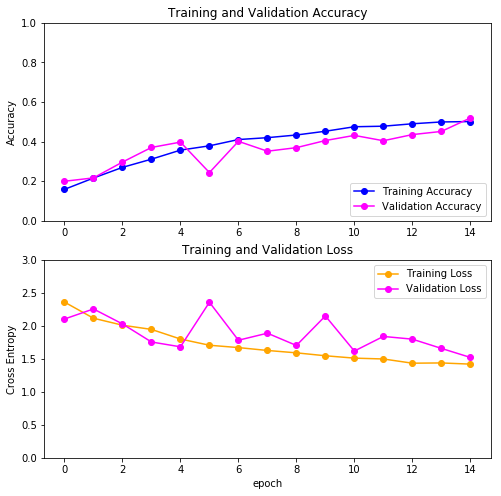

In [26]:
print(accuracy_score(np.argmax(y_test, axis = 1),model11.predict_classes(x_test)))
print(train_time_11)

acc = history_11.history['acc']
val_acc = history_11.history['val_acc']

loss = history_11.history['loss']
val_loss = history_11.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', marker='o', color="blue")
plt.plot(val_acc, label='Validation Accuracy', marker='o', color="magenta",)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', marker='o', color="orange")
plt.plot(val_loss, label='Validation Loss', marker='o', color="magenta",)
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### VGG16

- insufficient memory

In [25]:
# from tensorflow.keras.applications import *

In [56]:
# model3 = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))
# for l in model3.layers:
#     l.trainable = False
# #     print(l.name, l.trainable)

# # model3_top = Sequential([Flatten(input_shape=model3_bottom.output_shape[1:]),
# #                     Dense(500, activation='relu',use_bias=True),
# #                     Dense(100, activation='relu',use_bias=True),
# #                     Dense(10, activation='softmax')
    
# # ])

# # model3.add(Flatten(input_shape=(model3.output_shape[1:])))
# # model3.add(Dense(500, activation='relu',use_bias=True))
# # model3.add(Dense(100, activation='relu',use_bias=True))
# # model3.add(Dense(10, activation='softmax'))

# model3_top = Sequential()
# model3_top.add(Flatten(input_shape=(model3.output_shape[1:])))
# # model3_top.add(Dense(500, activation='relu',use_bias=True))
# # model3_top.add(Dense(100, activation='relu'))
# model3_top.add(Dense(10, activation='softmax'))

# model3 = Model(inputs=model3.input, outputs=model3_top(model3.output))

# # model3 = Model(inputs=model3.input, outputs=top_model(model3.output))

# # # only train the additional layers and the last layer of VGG16, freeze the rest
# # for layer in model3.layers[:-(len(top_model.layers)+1)]:
# #     layer.trainable = False

# model3.compile(optimizer=opt,
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

    
# model3.summary()

# for l in model3.layers:
#     print(l.name, l.trainable)
    
# # model3_top.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
# t3 = datetime.now()
# history_3= model3.fit(train_datagen.flow(x_train, y_train, batch_size=batch_size),
#                       steps_per_epoch=x_train.shape[0] // batch_size,
#                       epochs=epochs,
#                       verbose=1,
#                       validation_data=(x_test, y_test))

# train_time_3 = datetime.now() - t3

Train on 3500 samples, validate on 1500 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
  25/3500 [..............................] - ETA: 1:51:35 - loss: 2.5830 - acc: 0.0800